## **Install pyspark and import required libraries**

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 26 kB/s 
     |████████████████████████████████| 198 kB 61.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=040dc83ed99e943e9caad8bcb35e9f385481b2e2630856b565c743a5cf9aa521
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [ ]:
import pyspark
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import *
from pyspark.sql import Row
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [ ]:
from pyspark.sql import SparkSession

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"
import findspark
findspark.init()

In [ ]:
spark = SparkSession.builder.appName('test1').getOrCreate()
sc=spark.sparkContext

## **Loading dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

mainDF = spark.read.csv("/content/drive/MyDrive/data.csv", header=True, inferSchema=True)

Mounted at /content/drive


## **Displaying the schema of dataset**

In [ ]:
mainDF.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: double (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: double (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Label: string (nullable = true)



## **Displaying part of dataset**

In [ ]:
mainDF.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Label|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|5331-RGMTT|  Male|          1.0|    Yes|        No|  54.0|  

## **1- Data Preproccessing & EDA**

## **Data Proccessing**

### **Deleting duplicated data**

In [ ]:
#count the number of original data rows
n1 = mainDF.count()
print("number of original data rows: ", n1)
#count the number of data rows after deleting duplicated data
noDuplicatedDF = mainDF.dropDuplicates()
n2 = noDuplicatedDF.count()
print("number of data rows after deleting duplicated data: ", n2)
n3 = n1 - n2
print("number of duplicated data: ", n3)

number of original data rows:  229990
number of data rows after deleting duplicated data:  7838
number of duplicated data:  222152


### **Counting total missing values**

In [ ]:
noDuplicatedDF.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in noDuplicatedDF.columns]
   ).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Label|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|       253|   235|          266|    225|       242|   225|         269|          263|            230|           230|         243|             254|        264|        249|            219|     230|             257| 

### **Deleting missing values on 'Label' & 'customerID' columns**

In [ ]:
df = noDuplicatedDF.na.drop(subset=["Label"])
df = df.na.drop(subset=["customerID"])

### **Filling missing values on 'trnure', 'TotalCharges' & 'MonthlyCharges' columns with Means**

In [ ]:
TotCharges_Mean = df.select(["TotalCharges"]).toPandas().mean()[0]
df = df.na.fill( TotCharges_Mean,subset='TotalCharges')
MonthCharges_Mean = df.select(["MonthlyCharges"]).toPandas().mean()[0]
df = df.na.fill( MonthCharges_Mean,subset='MonthlyCharges')
tenure_Mean = df.select(["tenure"]).toPandas().mean()[0]
df = df.na.fill(tenure_Mean,subset='tenure')

In [ ]:
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: double (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: double (nullable = false)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = false)
 |-- TotalCharges: double (nullable = false)
 |-- Label: string (nullable = true)



### **Filling missing values on string type features with Modes**

In [ ]:
counts = df.groupBy("gender").count()
mode = counts.join(counts.agg(max("count").alias("max_")), col("count") == col("max_")).limit(1).select("gender")
df=df.na.fill(mode.first()[0],["gender"])

counts = df.groupBy("Partner").count()
mode = counts.join(counts.agg(max("count").alias("max_")), col("count") == col("max_")).limit(1).select("Partner")
df=df.na.fill(mode.first()[0],["Partner"])

counts = df.groupBy("Dependents").count()
mode = counts.join(counts.agg(max("count").alias("max_")), col("count") == col("max_")).limit(1).select("Dependents")
df=df.na.fill(mode.first()[0],["Dependents"])

counts = df.groupBy("MultipleLines").count()
mode = counts.join(counts.agg(max("count").alias("max_")), col("count") == col("max_")).limit(1).select("MultipleLines")
df=df.na.fill(mode.first()[0],["MultipleLines"])

counts = df.groupBy("InternetService").count()
mode = counts.join(counts.agg(max("count").alias("max_")), col("count") == col("max_")).limit(1).select("InternetService")
df=df.na.fill(mode.first()[0],["InternetService"])

counts = df.groupBy("OnlineSecurity").count()
mode = counts.join(counts.agg(max("count").alias("max_")), col("count") == col("max_")).limit(1).select("OnlineSecurity")
df=df.na.fill(mode.first()[0],["OnlineSecurity"])

counts = df.groupBy("OnlineBackup").count()
mode = counts.join(counts.agg(max("count").alias("max_")), col("count") == col("max_")).limit(1).select("OnlineBackup")
df=df.na.fill(mode.first()[0],["OnlineBackup"])

counts = df.groupBy("DeviceProtection").count()
mode = counts.join(counts.agg(max("count").alias("max_")), col("count") == col("max_")).limit(1).select("DeviceProtection")
df=df.na.fill(mode.first()[0],["DeviceProtection"])

counts = df.groupBy("TechSupport").count()
mode = counts.join(counts.agg(max("count").alias("max_")), col("count") == col("max_")).limit(1).select("TechSupport")
df=df.na.fill(mode.first()[0],["TechSupport"])

counts = df.groupBy("StreamingTV").count()
mode = counts.join(counts.agg(max("count").alias("max_")), col("count") == col("max_")).limit(1).select("StreamingTV")
df=df.na.fill(mode.first()[0],["StreamingTV"])

counts = df.groupBy("StreamingMovies").count()
mode = counts.join(counts.agg(max("count").alias("max_")), col("count") == col("max_")).limit(1).select("StreamingMovies")
df=df.na.fill(mode.first()[0],["StreamingMovies"])

counts = df.groupBy("PhoneService").count()
mode = counts.join(counts.agg(max("count").alias("max_")), col("count") == col("max_")).limit(1).select("PhoneService")
df=df.na.fill(mode.first()[0],["PhoneService"])

counts = df.groupBy("PaperlessBilling").count()
mode = counts.join(counts.agg(max("count").alias("max_")), col("count") == col("max_")).limit(1).select("PaperlessBilling")
df=df.na.fill(mode.first()[0],["PaperlessBilling"])

counts = df.groupBy("Contract").count()
mode = counts.join(counts.agg(max("count").alias("max_")), col("count") == col("max_")).limit(1).select("Contract")
df=df.na.fill(mode.first()[0],["Contract"])

counts = df.groupBy("PaymentMethod").count()
mode = counts.join(counts.agg(max("count").alias("max_")), col("count") == col("max_")).limit(1).select("PaymentMethod")
df=df.na.fill(mode.first()[0],["PaymentMethod"])

counts = df.groupBy("SeniorCitizen").count()
mode = counts.join(counts.agg(max("count").alias("max_")), col("count") == col("max_")).limit(1).select("SeniorCitizen")
df=df.na.fill(mode.first()[0],["SeniorCitizen"])


### **Counting missing values after applying last two stages**

In [ ]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]
   ).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Label|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|         0|     0|            0|      0|         0|     0|           0|            0|              0|             0|           0|               0|          0|          0|              0|       0|               0| 

## **EDA**

In [ ]:
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = false)
 |-- SeniorCitizen: double (nullable = false)
 |-- Partner: string (nullable = false)
 |-- Dependents: string (nullable = false)
 |-- tenure: double (nullable = false)
 |-- PhoneService: string (nullable = false)
 |-- MultipleLines: string (nullable = false)
 |-- InternetService: string (nullable = false)
 |-- OnlineSecurity: string (nullable = false)
 |-- OnlineBackup: string (nullable = false)
 |-- DeviceProtection: string (nullable = false)
 |-- TechSupport: string (nullable = false)
 |-- StreamingTV: string (nullable = false)
 |-- StreamingMovies: string (nullable = false)
 |-- Contract: string (nullable = false)
 |-- PaperlessBilling: string (nullable = false)
 |-- PaymentMethod: string (nullable = false)
 |-- MonthlyCharges: double (nullable = false)
 |-- TotalCharges: double (nullable = false)
 |-- Label: string (nullable = true)



In [ ]:
!pip install -q handyspark
from handyspark import *

### **Histogram of spread of each feature**

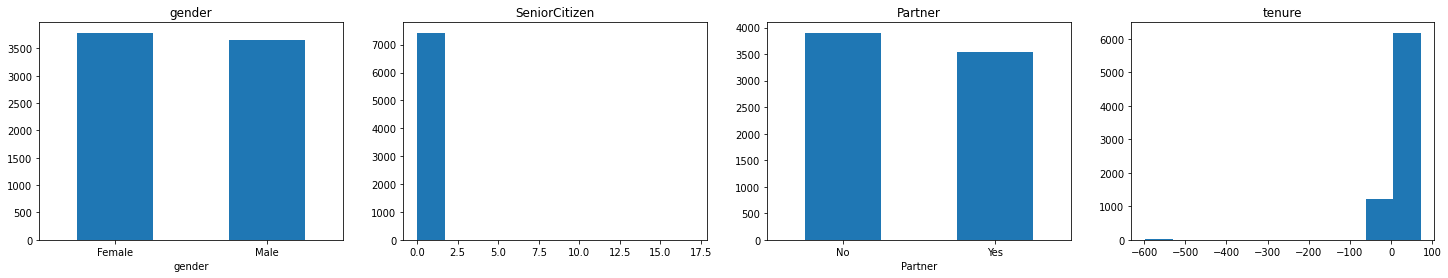

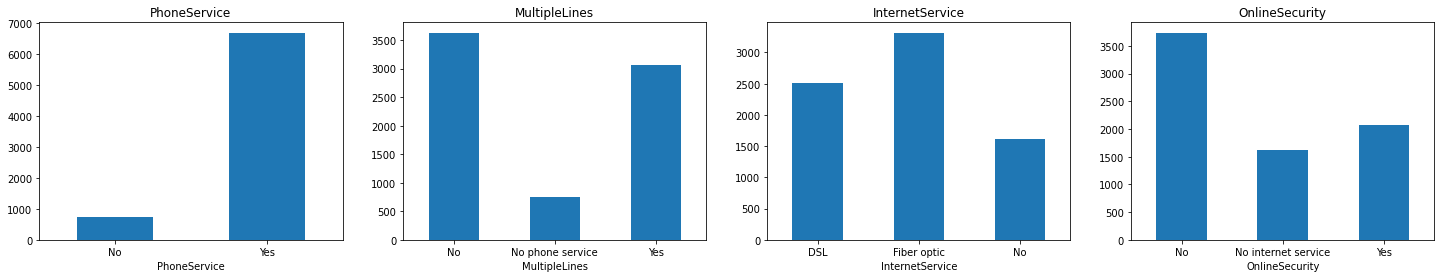

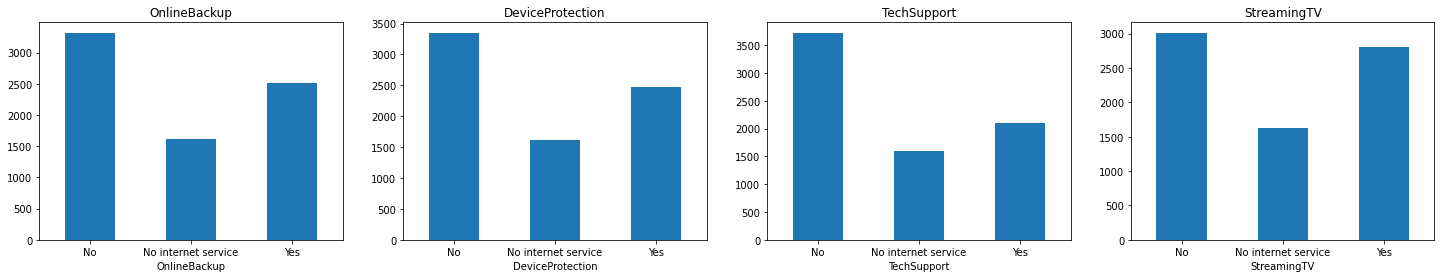

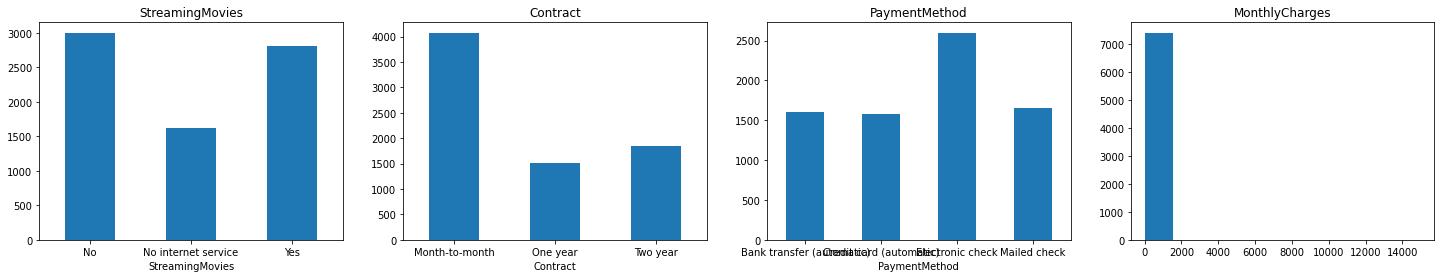

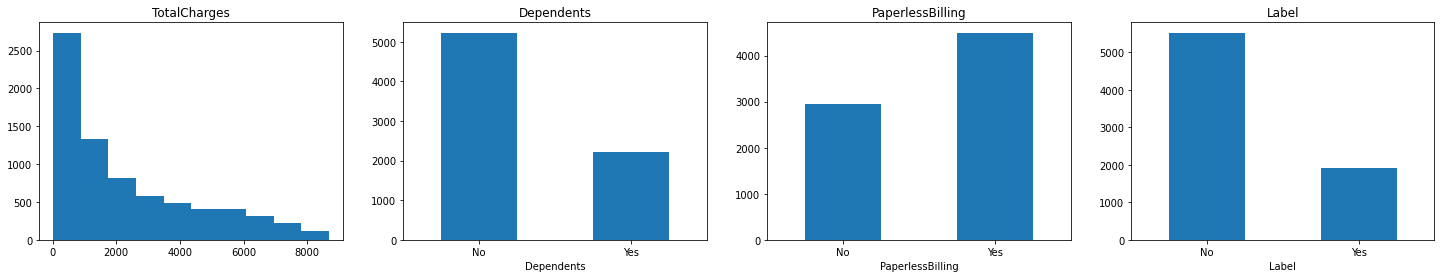

In [ ]:
hdf = df.toHandy()

from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(25, 4))
hdf.cols['gender'].hist(ax=axs[0])
hdf.cols['SeniorCitizen'].hist(ax=axs[1])
hdf.cols['Partner'].hist(ax=axs[2])
hdf.cols['tenure'].hist(ax=axs[3])

fig, axs = plt.subplots(1, 4, figsize=(25, 4))
hdf.cols['PhoneService'].hist(ax=axs[0])
hdf.cols['MultipleLines'].hist(ax=axs[1])
hdf.cols['InternetService'].hist(ax=axs[2])
hdf.cols['OnlineSecurity'].hist(ax=axs[3])

fig, axs = plt.subplots(1, 4, figsize=(25, 4))
hdf.cols['OnlineBackup'].hist(ax=axs[0])
hdf.cols['DeviceProtection'].hist(ax=axs[1])
hdf.cols['TechSupport'].hist(ax=axs[2])
hdf.cols['StreamingTV'].hist(ax=axs[3])

fig, axs = plt.subplots(1, 4, figsize=(25, 4))
hdf.cols['StreamingMovies'].hist(ax=axs[0])
hdf.cols['Contract'].hist(ax=axs[1])
hdf.cols['PaymentMethod'].hist(ax=axs[2])
hdf.cols['MonthlyCharges'].hist(ax=axs[3])

fig, axs = plt.subplots(1, 4, figsize=(25, 4))
hdf.cols['TotalCharges'].hist(ax=axs[0])
hdf.cols['Dependents'].hist(ax=axs[1])
hdf.cols['PaperlessBilling'].hist(ax=axs[2])
hdf.cols['Label'].hist(ax=axs[3])


### **Histogram of relation between 'Label' and each other feature**

(<Figure size 720x504 with 2 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7fb4d98db750>])

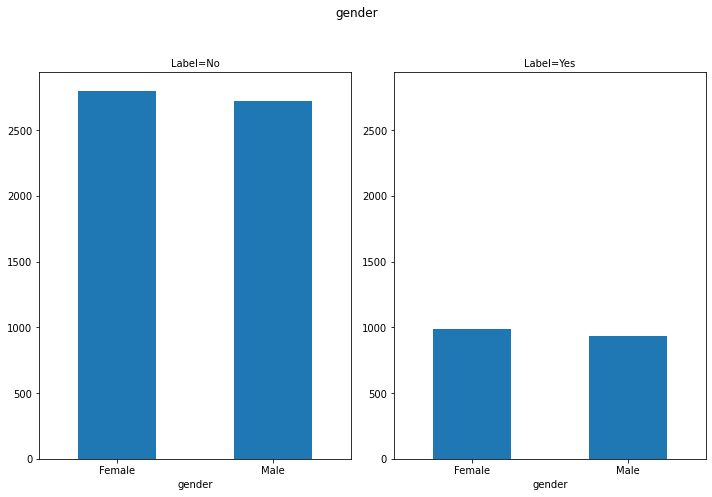

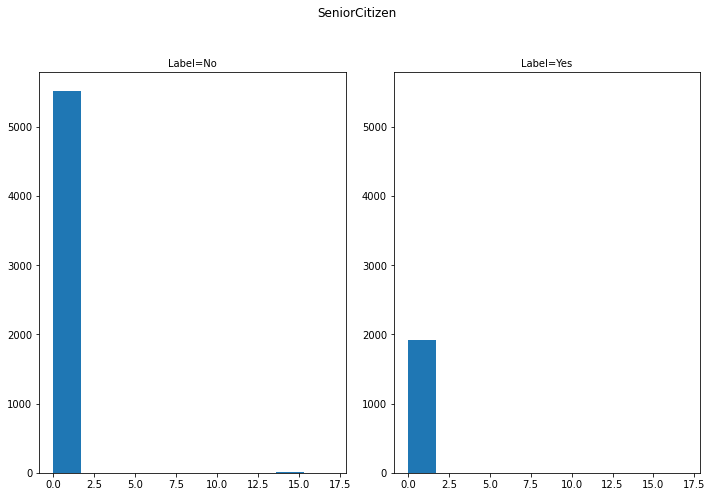

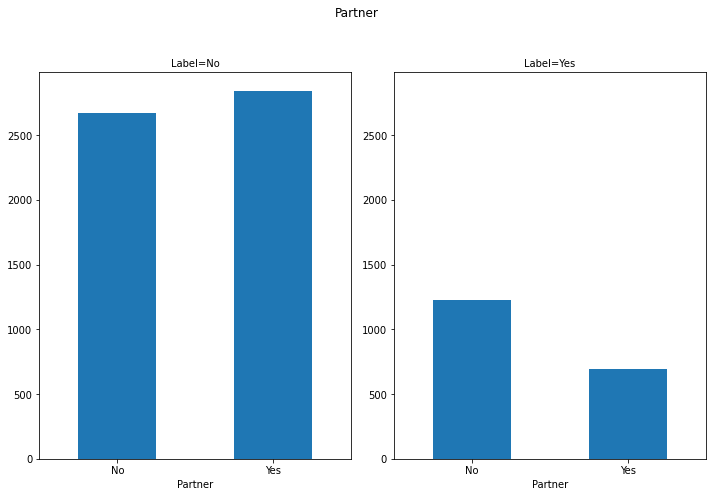

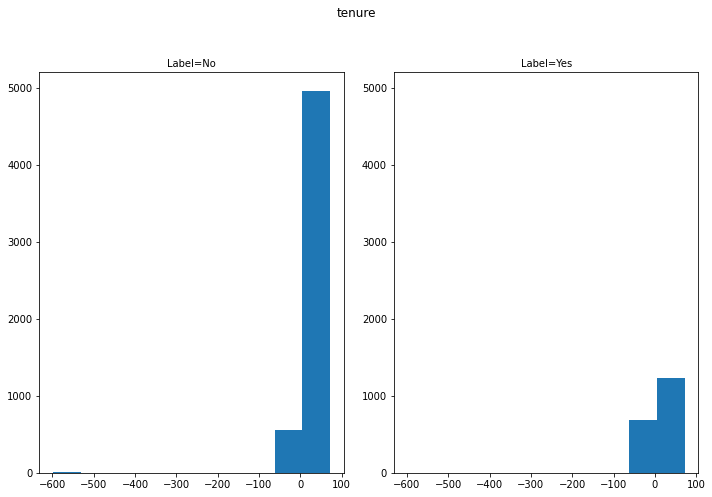

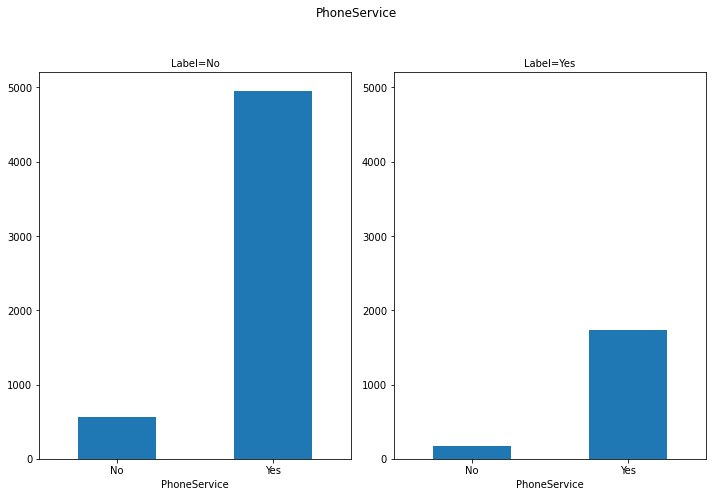

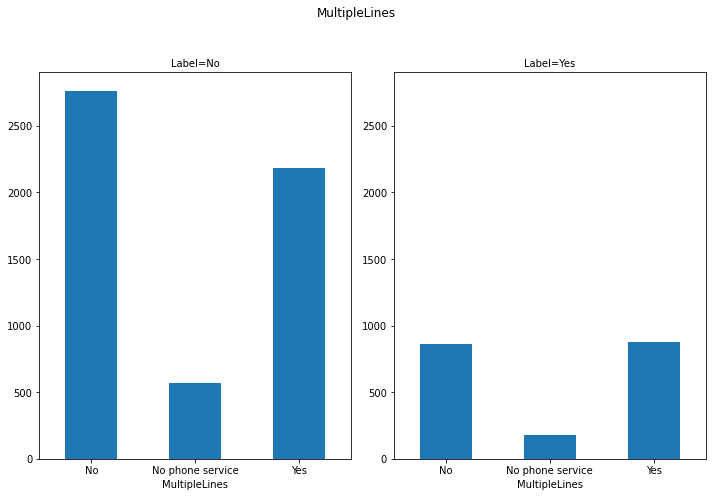

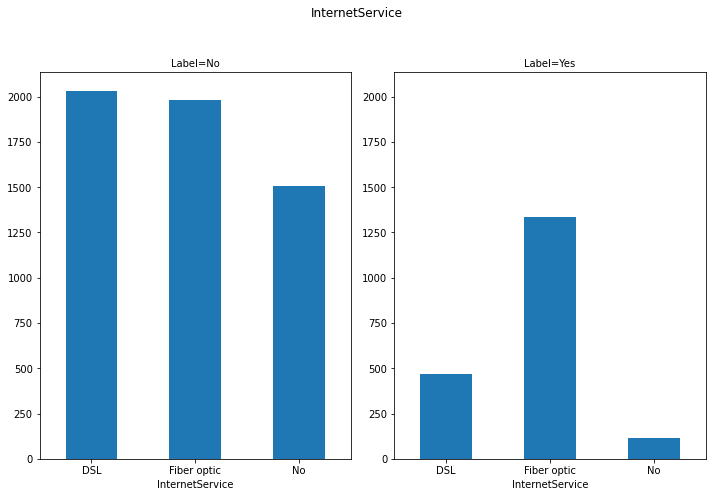

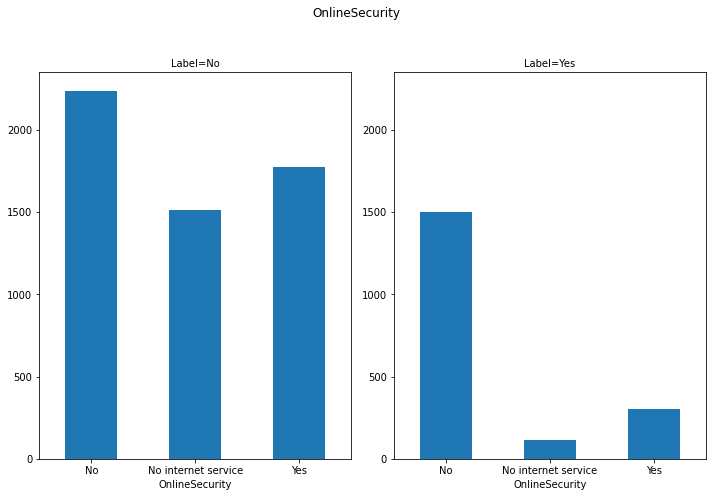

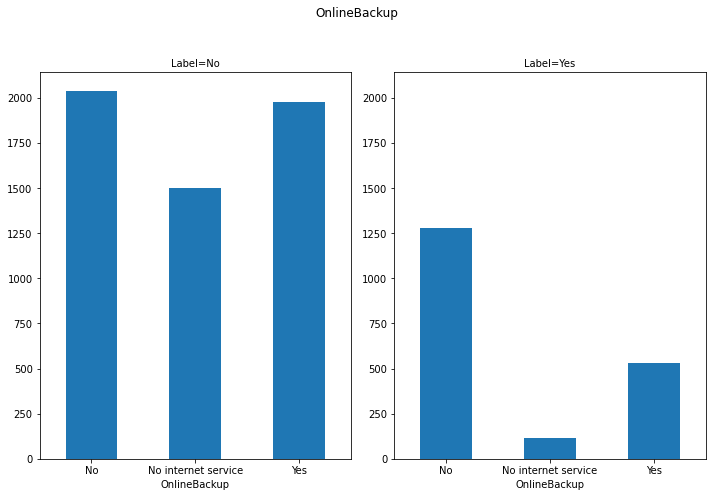

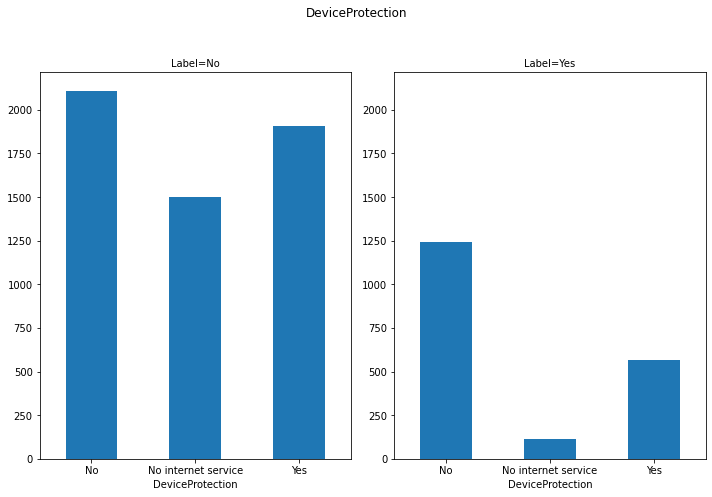

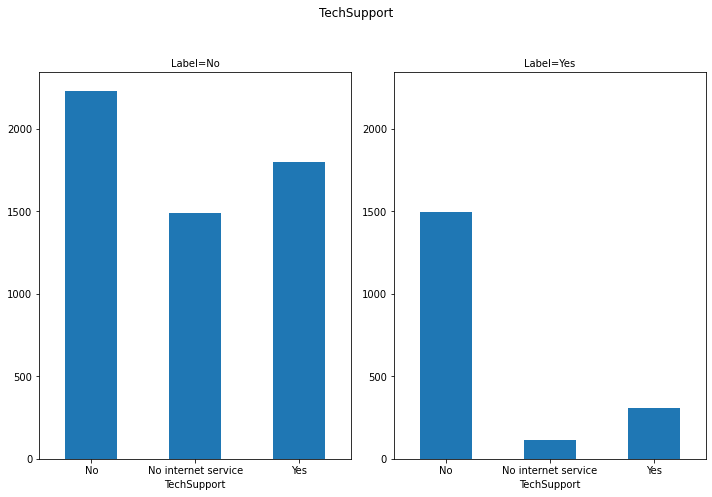

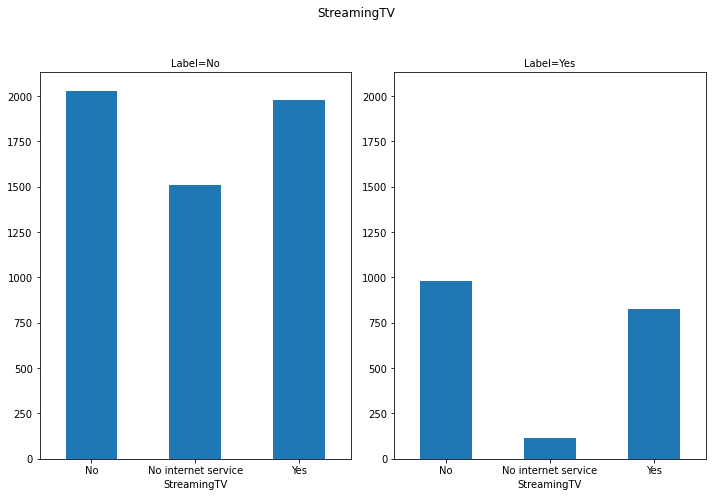

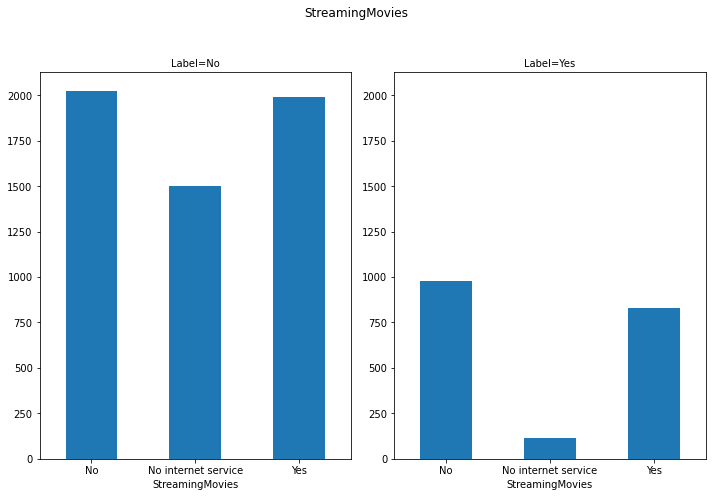

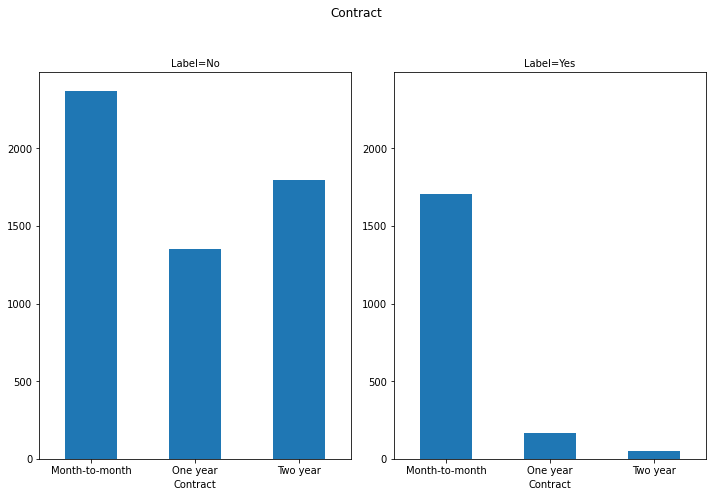

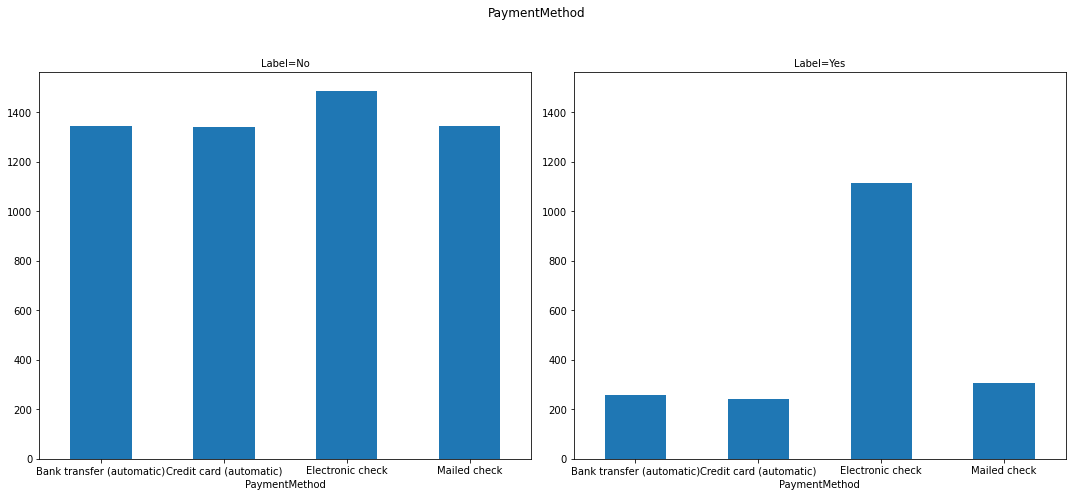

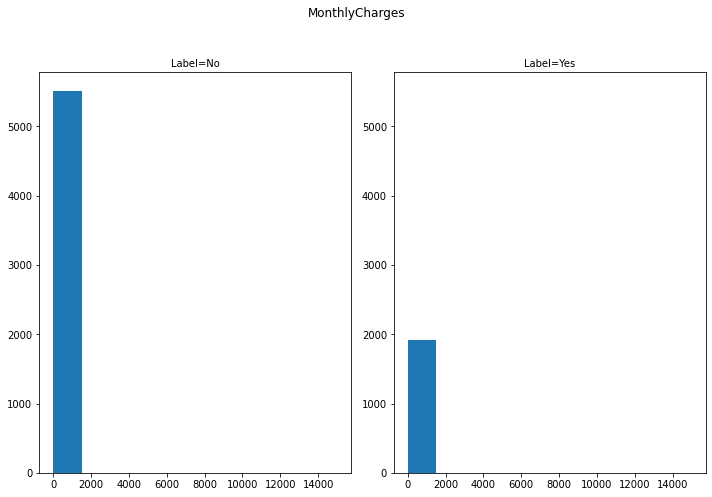

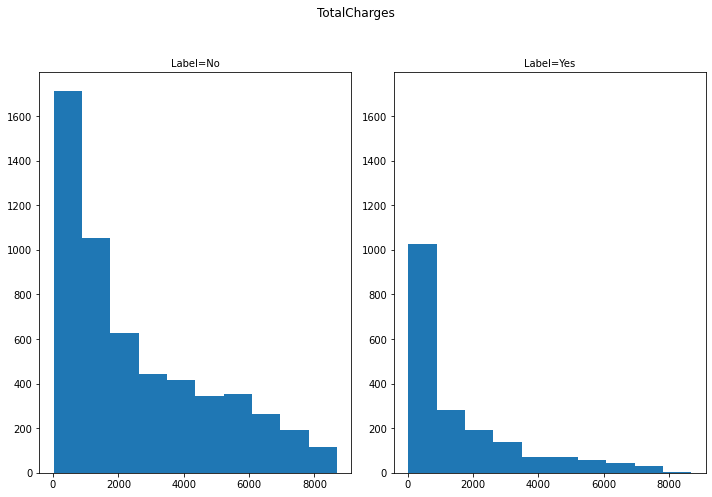

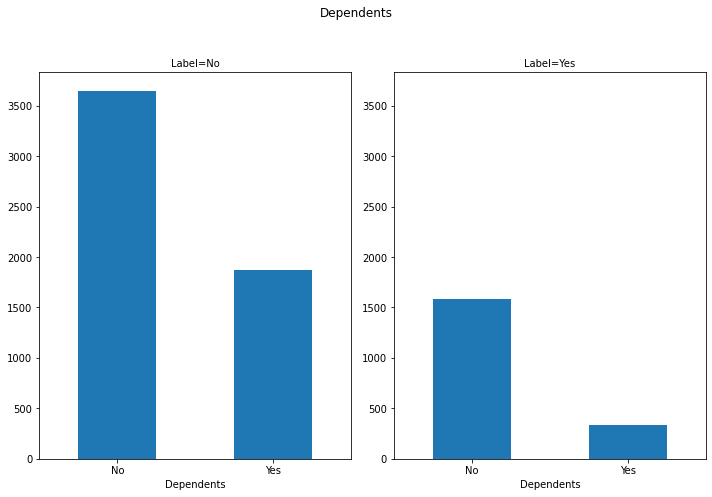

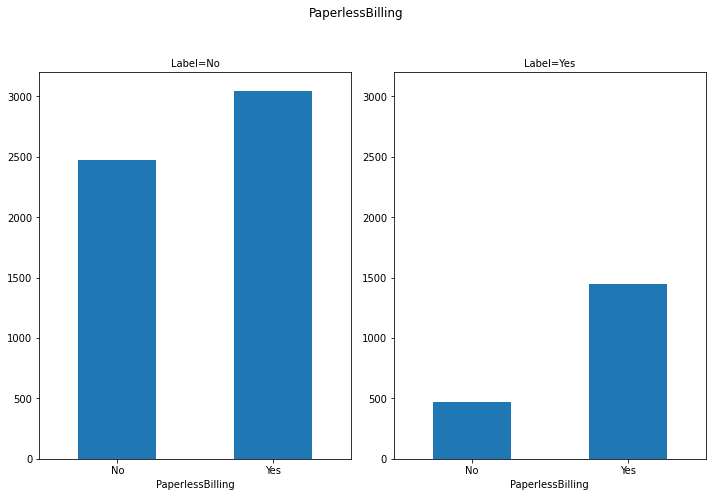

In [ ]:
hdf.stratify(['Label']).cols['gender'].hist(figsize=(10, 7))
hdf.stratify(['Label']).cols['SeniorCitizen'].hist(figsize=(10, 7))
hdf.stratify(['Label']).cols['Partner'].hist(figsize=(10, 7))
hdf.stratify(['Label']).cols['tenure'].hist(figsize=(10, 7))
hdf.stratify(['Label']).cols['PhoneService'].hist(figsize=(10, 7))
hdf.stratify(['Label']).cols['MultipleLines'].hist(figsize=(10, 7))
hdf.stratify(['Label']).cols['InternetService'].hist(figsize=(10, 7))
hdf.stratify(['Label']).cols['OnlineSecurity'].hist(figsize=(10, 7))
hdf.stratify(['Label']).cols['OnlineBackup'].hist(figsize=(10, 7))
hdf.stratify(['Label']).cols['DeviceProtection'].hist(figsize=(10, 7))
hdf.stratify(['Label']).cols['TechSupport'].hist(figsize=(10, 7))
hdf.stratify(['Label']).cols['StreamingTV'].hist(figsize=(10, 7))
hdf.stratify(['Label']).cols['StreamingMovies'].hist(figsize=(10, 7))
hdf.stratify(['Label']).cols['Contract'].hist(figsize=(10, 7))
hdf.stratify(['Label']).cols['PaymentMethod'].hist(figsize=(15,7))
hdf.stratify(['Label']).cols['MonthlyCharges'].hist(figsize=(10, 7))
hdf.stratify(['Label']).cols['TotalCharges'].hist(figsize=(10, 7))
hdf.stratify(['Label']).cols['Dependents'].hist(figsize=(10, 7))
hdf.stratify(['Label']).cols['PaperlessBilling'].hist(figsize=(10, 7))


### **ploting a heatmap to check correlation between featues**

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in list(set(df.columns)-set(['SeniorCitizen','tenure','MonthlyCharges','TotalCharges'])) ]


pipeline = Pipeline(stages=indexers)
df_r = pipeline.fit(df).transform(df)
df_r = df_r.drop('gender','Partner','Dependent','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod','Label','customerID','Dependents')
hdf1 = df_r.toHandy()


INFO: Safety is ON - returning up to 1000 instances.


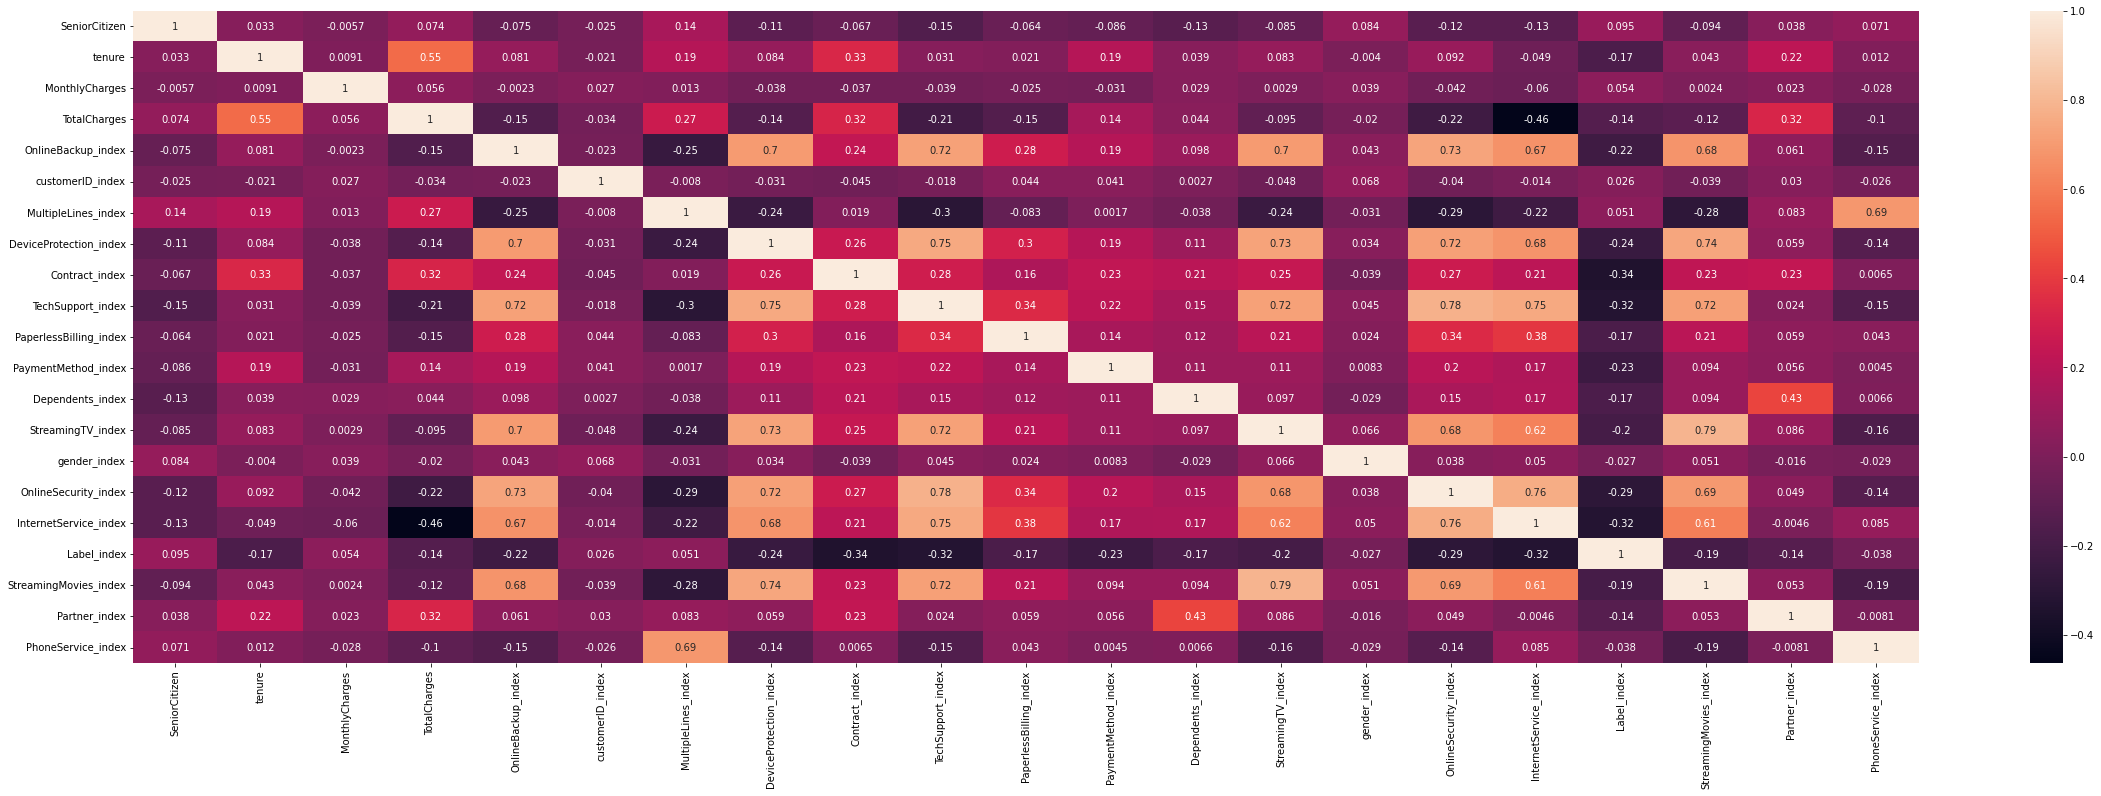

In [ ]:
from pyspark.ml.stat import Correlation
import seaborn as sns

data = hdf1.toPandas()
plt.figure(figsize=(40,12))
sns.heatmap(data.corr(), annot=True)
plt.show()

In [ ]:
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = false)
 |-- SeniorCitizen: double (nullable = false)
 |-- Partner: string (nullable = false)
 |-- Dependents: string (nullable = false)
 |-- tenure: double (nullable = false)
 |-- PhoneService: string (nullable = false)
 |-- MultipleLines: string (nullable = false)
 |-- InternetService: string (nullable = false)
 |-- OnlineSecurity: string (nullable = false)
 |-- OnlineBackup: string (nullable = false)
 |-- DeviceProtection: string (nullable = false)
 |-- TechSupport: string (nullable = false)
 |-- StreamingTV: string (nullable = false)
 |-- StreamingMovies: string (nullable = false)
 |-- Contract: string (nullable = false)
 |-- PaperlessBilling: string (nullable = false)
 |-- PaymentMethod: string (nullable = false)
 |-- MonthlyCharges: double (nullable = false)
 |-- TotalCharges: double (nullable = false)
 |-- Label: string (nullable = true)



## **2- Feature engineering**

In [285]:
Hasher = FeatureHasher(inputCols=["SeniorCitizen","Partner", "Dependents", "tenure", "PhoneService", "MultipleLines", "InternetService","OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "Contract","PaperlessBilling","PaymentMethod", "MonthlyCharges","TotalCharges"],
                       outputCol="features")
Hasher_main = FeatureHasher(inputCols=["gender", "SeniorCitizen", "Partner", "Dependents","tenure", "PhoneService", "MultipleLines", "InternetService","OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "Contract","PaperlessBilling","PaymentMethod", "MonthlyCharges", "TotalCharges"],
                       outputCol="features")
FeaturizedDF = Hasher.transform(df)
FeaturizedDF_main = Hasher_main.transform(noDuplicatedDF)
FeaturizedDF = FeaturizedDF["Label","customerID","features"]
FeaturizedDF_main = FeaturizedDF_main["Label","customerID","features"]

In [286]:
FeaturizedDF.show()

+-----+--------------+--------------------+
|Label|    customerID|            features|
+-----+--------------+--------------------+
|   No|    3655-SNQYZ|(262144,[20762,40...|
|   No|    7114-AEOZE|(262144,[20545,20...|
|  Yes|    8621-MNIHH|(262144,[20762,34...|
|  Yes|    4580-TMHJU|(262144,[7831,205...|
|   No|    5553-AOINX|(262144,[20762,34...|
|   No|    5902-WBLSE|(262144,[20545,20...|
|   No|    2388-LAESQ|(262144,[20762,34...|
|  Yes|    2506-CLAKW|(262144,[20545,20...|
|   No|    4976-LNFVV|(262144,[4236,783...|
|   No|    3642-GKTCT|(262144,[20762,34...|
|  Yes|    2223-KAGMX|(262144,[20545,20...|
|   No|    9003-CPATH|(262144,[7831,207...|
|   No|    7634-WSWDB|(262144,[4236,207...|
|   No|    6997-UVGOX|(262144,[20545,20...|
|  Yes|4412-YLTKFcsas|(262144,[7831,207...|
|   No|    3692-JHONH|(262144,[20762,34...|
|  Yes|    5202-IVJNU|(262144,[4236,783...|
|   No|    7879-CGSFV|(262144,[20545,20...|
|   No|    0582-AVCLN|(262144,[20545,20...|
|   No|    2229-VWQJH|(262144,[7

In [287]:
FeaturizedDF_main.show()

+-----+--------------+--------------------+
|Label|    customerID|            features|
+-----+--------------+--------------------+
|   No|    3655-SNQYZ|(262144,[20762,40...|
|   No|    7114-AEOZE|(262144,[20545,20...|
|  Yes|    8621-MNIHH|(262144,[20762,34...|
|  Yes|    4580-TMHJU|(262144,[7831,205...|
|   No|    5553-AOINX|(262144,[20762,34...|
|   No|    5902-WBLSE|(262144,[20545,20...|
|   No|    2388-LAESQ|(262144,[20762,34...|
|  Yes|    2506-CLAKW|(262144,[20545,20...|
|   No|    4976-LNFVV|(262144,[4236,783...|
|   No|    3642-GKTCT|(262144,[20762,34...|
|  Yes|    2223-KAGMX|(262144,[20545,20...|
|   No|    9003-CPATH|(262144,[7831,207...|
|   No|    7634-WSWDB|(262144,[4236,207...|
|   No|    6997-UVGOX|(262144,[20545,20...|
|  Yes|4412-YLTKFcsas|(262144,[20762,77...|
|   No|    3692-JHONH|(262144,[20762,34...|
|  Yes|    5202-IVJNU|(262144,[4236,783...|
|   No|    7879-CGSFV|(262144,[20545,20...|
|   No|    0582-AVCLN|(262144,[20545,20...|
|   No|    2229-VWQJH|(262144,[7

In [288]:
def f(x): 
    if(x == 'Yes'):
       return 1

    else:
       return 0

FeaturizedDF = FeaturizedDF.withColumn("label", when(col("Label")=='Yes', 1).otherwise(0))
FeaturizedDF = FeaturizedDF.withColumnRenamed("Label","label")
FeaturizedDF_main = FeaturizedDF_main.withColumn("label", when(col("Label")=='Yes', 1).otherwise(0))
FeaturizedDF_main = FeaturizedDF_main.withColumnRenamed("Label","label")
FeaturizedDF.show(10)
FeaturizedDF_main.show(10)

+-----+----------+--------------------+
|label|customerID|            features|
+-----+----------+--------------------+
|    0|3655-SNQYZ|(262144,[20762,40...|
|    0|7114-AEOZE|(262144,[20545,20...|
|    1|8621-MNIHH|(262144,[20762,34...|
|    1|4580-TMHJU|(262144,[7831,205...|
|    0|5553-AOINX|(262144,[20762,34...|
|    0|5902-WBLSE|(262144,[20545,20...|
|    0|2388-LAESQ|(262144,[20762,34...|
|    1|2506-CLAKW|(262144,[20545,20...|
|    0|4976-LNFVV|(262144,[4236,783...|
|    0|3642-GKTCT|(262144,[20762,34...|
+-----+----------+--------------------+
only showing top 10 rows

+-----+----------+--------------------+
|label|customerID|            features|
+-----+----------+--------------------+
|    0|3655-SNQYZ|(262144,[20762,40...|
|    0|7114-AEOZE|(262144,[20545,20...|
|    1|8621-MNIHH|(262144,[20762,34...|
|    1|4580-TMHJU|(262144,[7831,205...|
|    0|5553-AOINX|(262144,[20762,34...|
|    0|5902-WBLSE|(262144,[20545,20...|
|    0|2388-LAESQ|(262144,[20762,34...|
|    1|2506-CL

## **3- Applying logistic regression for label prediction**

### **Split data into two Train & Test sets**

In [329]:
Train, Test = FeaturizedDF.randomSplit(weights=[0.8,0.2])
Train_main, Test_main = FeaturizedDF_main.randomSplit(weights=[0.8,0.2])

### **An instance of logistic regression**

In [330]:
learn = LogisticRegression(maxIter=100,regParam=0.01)
learn.explainParams()

"aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)\nelasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)\nfamily: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)\nfeaturesCol: features column name. (default: features)\nfitIntercept: whether to fit an intercept term. (default: True)\nlabelCol: label column name. (default: label)\nlowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)\nlowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The bounds vector size must be

### **Learn the model and trained coefficents**

In [331]:
myModel = learn.fit(Train)
myModel.coefficients

SparseVector(262144, {4236: -0.173, 7831: -0.0807, 20545: -0.1048, 20762: 0.0, 34708: 0.149, 40671: 0.217, 53807: -0.1878, 57644: -0.1455, 59103: -0.2268, 62450: -0.1742, 72938: -0.9398, 74746: -0.0366, 77335: -0.0723, 97174: -0.1399, 97284: -0.1848, 100321: 0.0869, 109041: -0.0239, 112867: -0.0869, 119757: 0.1679, 124394: 0.1268, 139220: 0.2401, 139721: -0.0393, 143274: -0.0027, 144208: -0.374, 144894: -0.1268, 148734: 0.0366, 152436: -0.149, 153197: -0.1079, 163470: 0.2101, 180881: -0.2068, 190858: 0.1222, 190991: 0.248, 196278: 0.0696, 203276: 0.1735, 205898: 0.0576, 213513: -0.2068, 218283: 0.7602, 222701: 0.0768, 240448: -0.083, 241506: 0.4673, 246667: -0.0002, 256762: -0.1319, 257928: 0.0119})

In [332]:
mainModel = learn.fit(Train_main)
mainModel.coefficients

SparseVector(262144, {4236: 0.2519, 7831: 0.0061, 20545: 0.0654, 20762: 0.0, 34708: 0.2353, 35396: 0.157, 40671: 0.2874, 53807: -0.0436, 57644: -0.0416, 59103: -0.0255, 62450: -0.0289, 72938: -0.8148, 74746: -0.0407, 77335: -0.0988, 97174: -0.1692, 97284: -0.0236, 100321: 0.0959, 109041: -0.0201, 112867: -0.1362, 119757: 0.3286, 124394: 0.3881, 139220: 0.1735, 139721: 0.0124, 143274: -0.0018, 144208: -0.1841, 144894: 0.3855, 148734: 0.0222, 152436: -0.0901, 153197: -0.0122, 163470: 0.3233, 180881: -0.1956, 190858: 0.2046, 190991: 0.421, 196278: 0.2729, 203276: 0.2894, 205898: 0.0211, 213513: -0.0249, 218283: 0.7796, 222701: 0.0882, 240448: -0.1147, 241506: 0.6387, 246667: -0.0002, 253914: 0.2178, 256762: -0.038, 257928: 0.2848})

### **Test the model**

In [333]:
myModel_Pred = myModel.transform(Test)
myModel_Pred.show(10)

+-----+----------+--------------------+--------------------+--------------------+----------+
|label|customerID|            features|       rawPrediction|         probability|prediction|
+-----+----------+--------------------+--------------------+--------------------+----------+
|    0|0013-MHZWF|(262144,[20545,20...|[0.71953888401224...|[0.67250546810285...|       0.0|
|    0|0017-IUDMW|(262144,[20762,34...|[3.91331471191561...|[0.98041697241961...|       0.0|
|    0|0042-RLHYP|(262144,[20545,20...|[4.47572903044568...|[0.98874616888846...|       0.0|
|    0|0057-QBUQH|(262144,[20762,34...|[3.32746028959711...|[0.96535893941666...|       0.0|
|    0|0058-EVZWM|(262144,[7831,207...|[0.95046563396151...|[0.72120881113189...|       0.0|
|    0|0068-FIGTF|(262144,[20545,20...|[1.92285751795059...|[0.87245674533390...|       0.0|
|    0|0080-EMYVY|(262144,[7831,205...|[2.15267023030718...|[0.89591803630970...|       0.0|
|    0|0080-OROZO|(262144,[20545,20...|[0.85682358804440...|[0.7019965

In [334]:
mainModel_Pred = mainModel.transform(Test_main)
mainModel_Pred.show()

+-----+----------+--------------------+--------------------+--------------------+----------+
|label|customerID|            features|       rawPrediction|         probability|prediction|
+-----+----------+--------------------+--------------------+--------------------+----------+
|    0|      null|(262144,[4236,207...|[1.05026208208542...|[0.74082522296030...|       0.0|
|    0|      null|(262144,[4236,207...|[2.31498328346011...|[0.91011036918389...|       0.0|
|    0|      null|(262144,[4236,207...|[2.66134980308647...|[0.93470709306301...|       0.0|
|    0|      null|(262144,[4236,207...|[3.75079123141808...|[0.97704038606612...|       0.0|
|    0|      null|(262144,[4236,347...|[2.13734573359031...|[0.89448034905230...|       0.0|
|    0|      null|(262144,[7831,205...|[0.54896564379470...|[0.63389557918655...|       0.0|
|    0|      null|(262144,[7831,205...|[4.10003237854535...|[0.98369801986634...|       0.0|
|    0|      null|(262144,[7831,205...|[2.75800070474847...|[0.9403636

## **4- Model Evaluation**

In [335]:
myModel_Pred.groupBy('label', 'Prediction').count().show()

# Calculate the elements of the confusion matrix
TN = myModel_Pred.filter('Prediction = 0 AND label = Prediction').count()
TP = myModel_Pred.filter('Prediction = 1 AND label = Prediction').count()
FN = myModel_Pred.filter('Prediction = 0 AND label = 1').count()
FP = myModel_Pred.filter('Prediction = 1 AND label = 0').count()

# Accuracy measures the proportion of correct predictions
Accuracy = (TN + TP) / (TN + TP + FN + FP)
Precision = TP/(TP+FP)
print("My model accuracy:", Accuracy)
print("My model precision:", Precision)

+-----+----------+-----+
|label|Prediction|count|
+-----+----------+-----+
|    1|       0.0|  185|
|    0|       0.0| 1025|
|    1|       1.0|  199|
|    0|       1.0|  101|
+-----+----------+-----+

My model accuracy: 0.8105960264900662
My model precision: 0.6633333333333333


In [336]:
mainModel_Pred.groupBy('label', 'Prediction').count().show()

# Calculate the elements of the confusion matrix
TN = mainModel_Pred.filter('Prediction = 0 AND label = Prediction').count()
TP = mainModel_Pred.filter('Prediction = 1 AND label = Prediction').count()
FN = mainModel_Pred.filter('Prediction = 0 AND label = 1').count()
FP = mainModel_Pred.filter('Prediction = 1 AND label = 0').count()

# Accuracy measures the proportion of correct predictions
Accuracy = (TN + TP) / (TN + TP + FN + FP)
Precision = TP/(TP+FP)
print("Main model accuracy:", Accuracy)
print("Main model precision:", Precision)

+-----+----------+-----+
|label|Prediction|count|
+-----+----------+-----+
|    1|       0.0|  217|
|    0|       0.0| 1071|
|    1|       1.0|  195|
|    0|       1.0|  121|
+-----+----------+-----+

Main model accuracy: 0.7892768079800498
Main model precision: 0.6170886075949367
